# Tax Rates For Each County

In [2]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#import functions from my .py files
from acquire import get_zillow_data
from prep import remove_outlier, clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale, clean_zillow_taxes, remove_outlier_tax
from explore import plot_variable_pairs, plot_pairplot, correlation_exploration, get_zillow_heatmap

In [3]:
#Now we need to calculate tax rate for each county, an approximate actually.
#I'm going to rebring in the original Zillow dataset.
df = get_zillow_data()
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,NaN,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,NaN,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,NaN,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,NaN,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,NaN,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,NaN,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,NaN,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,NaN,NaN,6.037108e+13,72843,0.024946,2017-08-31


In [4]:
#Made a new clean function for taxes, I also included tax_amount to calculate tax_rate. 
# tax_rate = tax_amount / tax_value 
new_tax = clean_zillow_taxes(df)
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate
parcel_id,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270
...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081


In [5]:
#Now we're going to remove outliers, just in case anything is a bit extreme. 
new_tax = remove_outlier_tax(new_tax)

In [6]:
#going to create a new column called county, and it's going to give us the county name based off the FIPS number. 
#yes, I had to look up the FIPS numbers
new_tax['county'] = new_tax['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [7]:
#make a new dataframe, going to group by county name, and calculate the mean tax_rate. I multiplied it by 100 for the percent. 
county_mean_tax_rate = pd.DataFrame(round(new_tax.groupby('county').tax_rate.mean(), 4)*100)
county_mean_tax_rate.columns = ['tax_rate_percent']
county_mean_tax_rate

,tax_rate_percent
county,
Los Angeles,1.38
Orange,1.20
Ventura,1.19


In [8]:
#let's pull all of the tax rates from each county to graph a distribution. 
los_angeles_tax = new_tax[new_tax.county == "Los Angeles"].tax_rate
orange_tax = new_tax[new_tax.county == "Orange"].tax_rate
ventura_tax = new_tax[new_tax.county == "Ventura"].tax_rate

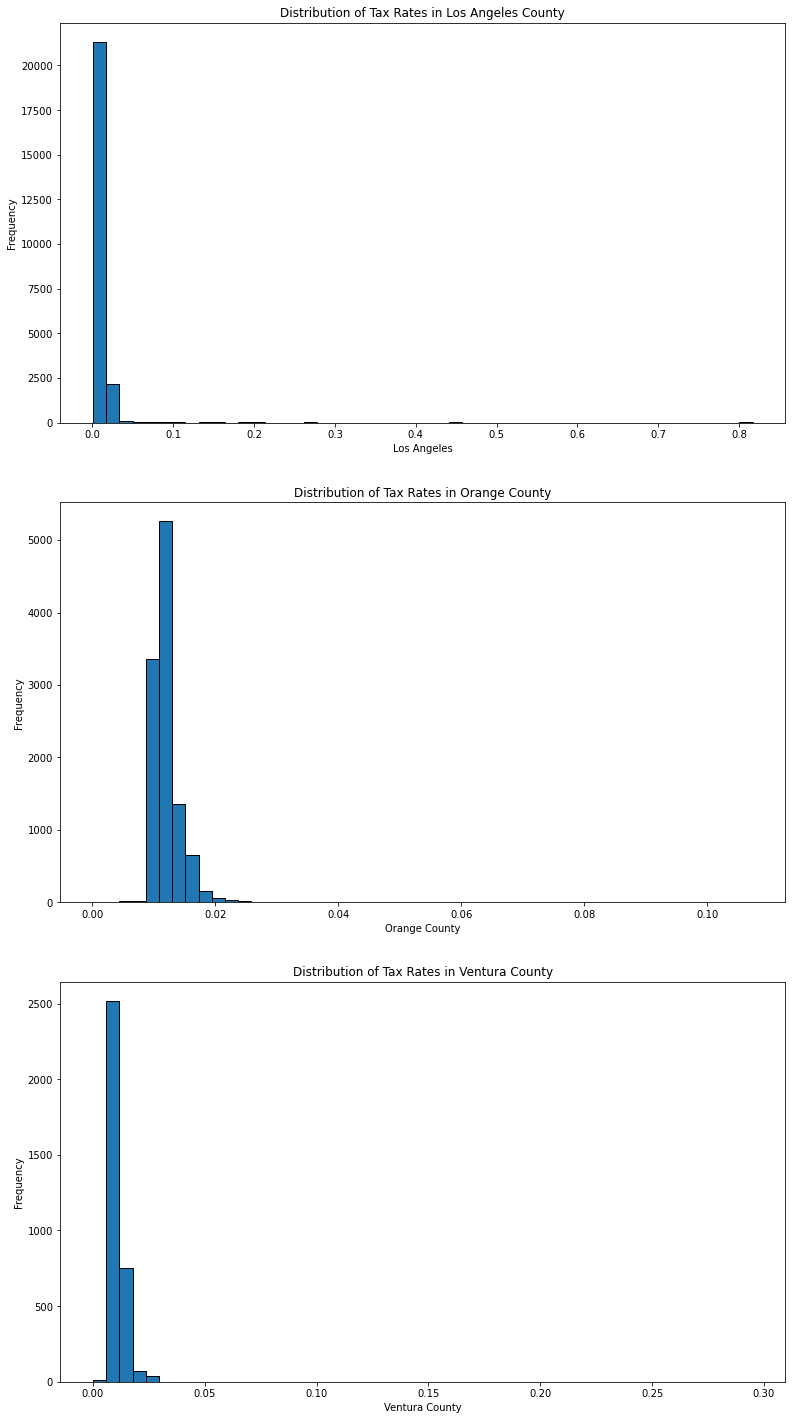

In [14]:
plt.figure(figsize=(13,25))
plt.subplot(3,1,1, xlabel = 'Los Angeles',ylabel = 'Frequency', title='Distribution of Tax Rates in Los Angeles County')
plt.hist(data=new_tax[new_tax.fips == 6037],bins=50, x='tax_rate',ec='black')

plt.subplot(3,1,2, xlabel = 'Orange County', ylabel = 'Frequency', title='Distribution of Tax Rates in Orange County')
plt.hist(data=new_tax[new_tax.fips == 6059],bins=50, x='tax_rate', ec='black')

plt.subplot(3,1,3, xlabel = 'Ventura County', ylabel = 'Frequency', title='Distribution of Tax Rates in Ventura County')
plt.hist(data=new_tax[new_tax.fips == 6111],bins=50, x='tax_rate',ec='black')

plt.show()

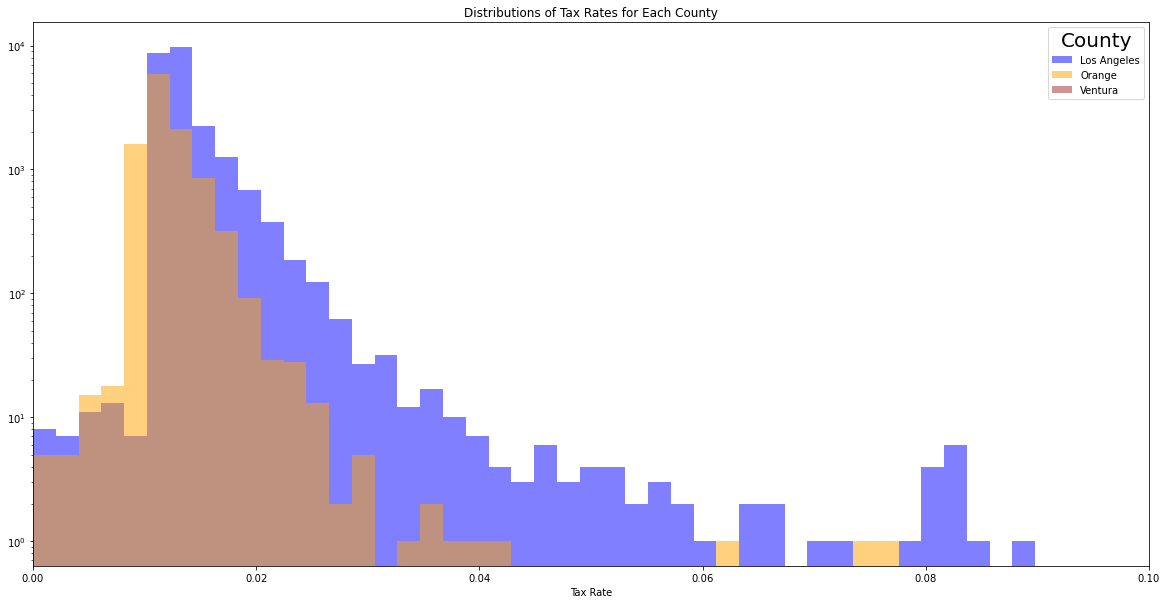

In [15]:
#all the tax distributions on one graph
plt.figure(figsize=(20,10))
    # start plot
plt.hist(new_tax[new_tax.county == 'Los Angeles'].tax_rate, bins=np.linspace(0, 0.1, 50), color='blue', alpha=0.50, log=True, label='Los Angeles')
plt.hist(new_tax[new_tax.county == 'Orange'].tax_rate, bins=np.linspace(0, 0.1, 50), color='orange', alpha=0.50, log=True, label='Orange')
plt.hist(new_tax[new_tax.county == 'Venture'].tax_rate, bins=np.linspace(0, 0.1, 50), color='brown', alpha=0.50, log=True, label='Ventura')
plt.rcParams['legend.title_fontsize'] = 20
plt.xlim(0, 0.1)
plt.xlabel('Tax Rate')
plt.title('Distributions of Tax Rates for Each County')
plt.legend(title='County')
plt.show()

Takeaways:

Most properties in our set was from Los Angeles, and have higher tax rates than Orange or Ventura county.

Los Angeles County, even after dropping outliers, is skewed to the right on tax rates.

Orange and Ventura county seem to have very close tax rates, but seems to be more diversity in Orange.

In [16]:
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [17]:
new_tax.to_csv('county_tax.csv')

In [18]:
#and this little dataframe too just in case we want to see it later
county_mean_tax_rate.to_csv('tax_rates')